# Importing Libraries

In [1]:
import numpy as np
import pandas as pd 
import random as rn

# tensorflow
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Chart
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import glob
from pathlib import Path

from skimage import color, exposure
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import os
import cv2

# Setting the same seed for repeatability

seed = 0

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


# Loading data

In [2]:
cd drive/MyDrive/Colab Notebooks/Covid_detection

/content/drive/MyDrive/Colab Notebooks/Covid_detection


In [3]:
pneumonia_bacterial = np.load('Data/pneumonia_bacterial.npy')
covid = np.load('Data/covid.npy')
normal = np.load('Data/normal.npy')
pneumonia_viral = np.load('Data/pneumonia_viral.npy')

pneumonia_bacterial = pneumonia_bacterial.reshape(-1, 256*256)
covid = covid.reshape(-1, 256*256)
normal = normal.reshape(-1, 256*256)
pneumonia_viral = pneumonia_viral.reshape(-1, 256*256)

In [4]:
def f(x):
    if x == 0:
        return 'normal'
    elif x == 1:
        return 'pneumonia_bacterial'
    elif x == 2:
        return 'pneumonia_viral'
    elif x == 3:
        return 'covid'

In [5]:
df0 = pd.DataFrame([(img,0) for img in normal],columns=['img', 'label'])
df1 = pd.DataFrame([(img,1) for img in pneumonia_bacterial],columns=['img', 'label'])
df2 = pd.DataFrame([(img,2) for img in pneumonia_viral],columns=['img', 'label'])
df3 = pd.DataFrame([(img,3) for img in covid],columns=['img', 'label'])
del pneumonia_bacterial, normal, covid, pneumonia_viral

df = pd.concat((df0,df1,df2,df3)).reset_index()
del df0, df1, df2, df3

X = np.stack(df['img'])
y = df['label']
del df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.01, random_state=seed)
del X, y

# CNN

## Preprocessing

In [9]:
X_train = X_train.reshape(-1, 256, 256, 1)
X_test = X_test.reshape(-1, 256, 256, 1)
X_val = X_val.reshape(-1, 256, 256, 1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

input_shape = (256, 256, 1)
num_classes = y_train.shape[1]

In [7]:
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='best')
    plt.show()

In [8]:
def get_callback(num):
    return [ 
        EarlyStopping(monitor = 'loss', patience = 6), 
        ReduceLROnPlateau(monitor = 'loss', patience = 3), 
        ModelCheckpoint('models/model.best{}.hdf5'.format(num),monitor='loss', save_best_only=True) # saving the best model
    ]

## First cnn model

In [9]:
callbacks = get_callback(3)

In [10]:
def get_modelcnn():
    return Sequential([
        
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(0.8),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.7),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(num_classes, activation = "softmax")
        
    ])

In [11]:
model = get_modelcnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 127, 127, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 32)      9

In [12]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 128)

In [13]:
learning_history = model.fit_generator((train_gen), 
        epochs = 100,
        steps_per_epoch = X_train.shape[0] // 128,
        validation_data = (X_test, y_test),
        callbacks = callbacks,
        )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
56/56 [==============================] - 55s 984ms/step - loss: 1.8442 - accuracy: 0.3344 - val_loss: 6.1083 - val_accuracy: 0.1362
Epoch 2/100
56/56 [==============================] - 55s 985ms/step - loss: 1.2490 - accuracy: 0.5238 - val_loss: 3.9304 - val_accuracy: 0.3262
Epoch 3/100
56/56 [==============================] - 55s 986ms/step - loss: 0.9657 - accuracy: 0.6303 - val_loss: 6.2632 - val_accuracy: 0.1362
Epoch 4/100
56/56 [==============================] - 55s 975ms/step - loss: 0.8291 - accuracy: 0.6768 - val_loss: 3.4476 - val_accuracy: 0.3292
Epoch 5/100
56/56 [==============================] - 55s 983ms/step - loss: 0.7564 - accuracy: 0.6973 - val_loss: 3.3681 - val_accuracy: 0.3262
Epoch 6/100
56/56 [==============================] - 55s 979ms/step - loss: 0.7017 - accuracy: 0.7155 - val_loss: 4.4820 - val_accuracy: 0.1362
Epoch 7/100
56/56 [==============================] - 54s 970

In [10]:
model = load_model('models/model.best3.hdf5')

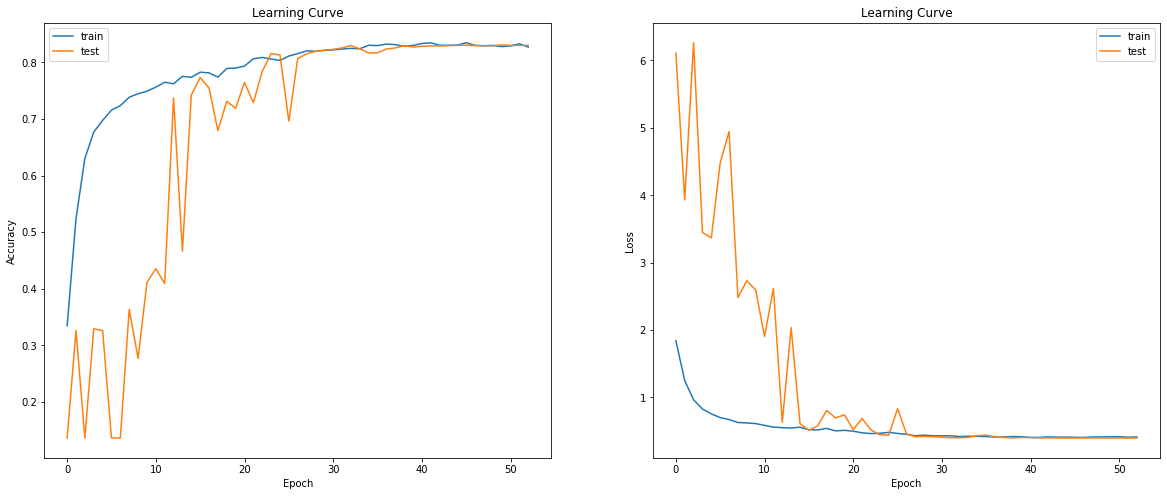

In [15]:
draw_learning_curve(learning_history)

In [11]:
scores = []

In [12]:
score = model.evaluate(X_train, y_train, verbose = 0)
print('Train loss: {}%'.format(score[0] * 100))
print('Train accuracy: {}%'.format(score[1] * 100))

print("Train Error: %.2f%%" % (100 - score[1] * 100))

score_train = {'Train loss':score[0] * 100, 'Train accuracy':score[1] * 100, 'Train Error':(100 - score[1] * 100)}

Train loss: 35.45549511909485%
Train accuracy: 84.76747274398804%
Train Error: 15.23%


In [13]:
scores = score_train

In [14]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("Test Error: %.2f%%" % (100 - score[1] * 100))

score_test = {'Test loss':score[0] * 100, 'Test accuracy':score[1] * 100, 'Test Error':(100 - score[1] * 100)}

Test loss: 39.9223655462265%
Test accuracy: 82.94264078140259%
Test Error: 17.06%


In [15]:
scores.update(score_test)

In [16]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Valid loss: {}%'.format(score[0] * 100))
print('Valid accuracy: {}%'.format(score[1] * 100))

print("Valid Error: %.2f%%" % (100 - score[1] * 100))
score_valid = {'Valid loss':score[0] * 100, 'Valid accuracy':score[1] * 100, 'Valid Error':(100 - score[1] * 100)}

Valid loss: 39.25751745700836%
Valid accuracy: 80.95238208770752%
Valid Error: 19.05%


In [17]:
scores.update(score_valid)

In [18]:
scores

{'Test Error': 17.057359218597412,
 'Test accuracy': 82.94264078140259,
 'Test loss': 39.9223655462265,
 'Train Error': 15.232527256011963,
 'Train accuracy': 84.76747274398804,
 'Train loss': 35.45549511909485,
 'Valid Error': 19.04761791229248,
 'Valid accuracy': 80.95238208770752,
 'Valid loss': 39.25751745700836}

In [23]:
score = pd.DataFrame(scores,index = ['CNN'])

In [24]:
results = pd.read_csv('models/score.csv', index_col='Unnamed: 0')

In [35]:
score = pd.concat((results, score), axis=0)

In [36]:
score.to_csv('models/score.csv')

In [37]:
score

,Train loss,Train accuracy,Train Error,Test loss,Test accuracy,Test Error,Valid loss,Valid accuracy,Valid Error
Simple MLP,42.815587,82.052356,17.947644,47.158113,80.199504,19.800496,44.728607,76.190478,23.809522
CNN,35.455495,84.767473,15.232527,39.922366,82.942641,17.057359,39.257517,80.952382,19.047618
